In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm
from itertools import product

In [3]:
from codecarbon import EmissionsTracker

codecarbon_output = "./codecarbon_emissions.csv"

In [44]:
df = pd.read_csv('./final-data-pre-processed.csv', sep=',')
df

,DATA,HORA,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",timestamp
0,2007-05-18,18:00:00,0.0,1010.0,1010.1,1010.0,100.8,23.5,21.1,23.8,23.5,21.2,21.1,87.0,85.0,86.0,224.0,6.4,4.6,2007-05-18 18:00:00
1,2007-05-18,19:00:00,0.0,1010.4,1010.4,1010.3,35.6,23.2,21.0,23.3,23.2,21.1,20.7,88.0,86.0,87.0,234.0,7.9,5.5,2007-05-18 19:00:00
2,2007-05-19,11:00:00,0.0,1013.2,1013.2,1013.1,91.2,23.6,19.3,23.6,23.1,19.3,18.2,77.0,74.0,77.0,37.0,2.0,0.4,2007-05-19 11:00:00
3,2007-05-19,12:00:00,0.0,1013.5,1013.5,1013.2,141.0,23.9,20.6,23.9,23.6,20.6,19.4,82.0,77.0,82.0,104.0,1.5,0.9,2007-05-19 12:00:00
4,2007-05-19,13:00:00,0.0,1013.8,1013.9,1013.8,428.8,25.0,19.3,25.0,24.3,19.5,19.0,74.0,71.0,71.0,239.0,5.4,3.9,2007-05-19 13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145134,2024-02-16,14:00:00,0.0,1010.5,1010.6,1010.4,2954.0,26.4,23.3,26.8,26.2,23.5,23.0,84.0,81.0,83.0,265.0,10.5,4.2,2024-02-16 14:00:00
145135,2024-02-16,15:00:00,0.0,1010.1,1010.6,1010.0,2329.2,26.5,23.2,26.5,25.4,23.5,22.5,86.0,82.0,82.0,268.0,11.7,4.3,2024-02-16 15:00:00
145136,2024-02-16,16:00:00,0.0,1009.7,1010.1,1009.7,2605.8,26.3,23.3,27.0,25.9,23.7,22.8,84.0,79.0,83.0,261.0,10.3,4.6,2024-02-16 16:00:00
145137,2024-02-16,17:00:00,0.0,1009.6,1009.7,1009.5,1389.0,25.6,23.2,26.5,25.5,23.5,22.9,87.0,83.0,87.0,263.0,10.3,4.0,2024-02-16 17:00:00


In [29]:
# df = df.drop(columns='Unnamed: 0') 
# df['timestamp'] = pd.to_datetime(df['DATA'] + ' ' + df['HORA'])

In [45]:
df.isna().sum()

DATA                                                     0
HORA                                                     0
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                         0
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    0
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          0
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)         0
RADIACAO GLOBAL (KJ/m²)                                  0
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)             0
TEMPERATURA DO PONTO DE ORVALHO (°C)                     0
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)               0
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)               0
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)         0
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)         0
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 0
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                 0
UMIDADE RELATIVA DO AR, HORARIA (%)                      0
VENTO, DIREÇÃO HORARIA (gr) (° (gr))                    

- como a preciptação é a principal variável, dropar todas as colunas onde a preciptação é NaN
- transformar todos os valores faltantesda coluna radiação em 0

In [31]:
# df = df.dropna(subset=['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'])
# df['RADIACAO GLOBAL (KJ/m²)'] = df['RADIACAO GLOBAL (KJ/m²)'].fillna(0)

/tmp/ipykernel_5303/80260996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RADIACAO GLOBAL (KJ/m²)'] = df['RADIACAO GLOBAL (KJ/m²)'].fillna(0)


In [32]:
# columns_to_interpolate = df.select_dtypes(include=['float64']).columns

# df[columns_to_interpolate] = df[columns_to_interpolate].interpolate(limit_direction='both')

/tmp/ipykernel_5303/3120306077.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_interpolate] = df[columns_to_interpolate].interpolate(limit_direction='both')


In [47]:
df.dtypes

DATA                                                      object
HORA                                                      object
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                         float64
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    float64
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          float64
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)         float64
RADIACAO GLOBAL (KJ/m²)                                  float64
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)             float64
TEMPERATURA DO PONTO DE ORVALHO (°C)                     float64
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)               float64
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)               float64
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)         float64
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)         float64
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 float64
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                 float64
UMIDADE RELATIVA DO AR, H

In [11]:
# df['lag_preciptation_1h'] = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].shift(-1).fillna(0)
# df['lag_preciptation_2h'] = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].shift(-2).fillna(0)
# df['lag_preciptation_3h'] = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].shift(-3).fillna(0)
# df['lag_preciptation_4h'] = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].shift(-4).fillna(0)

In [48]:
df.shape

(145139, 20)

In [13]:
df.columns

Index(['DATA', 'HORA', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (KJ/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)', 'timestamp'],
      dtype='object')

In [43]:
df

,DATA,HORA,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",timestamp
18,2007-05-18,18:00:00,0.0,1010.0,1010.1,1010.0,100.8,23.5,21.1,23.8,23.5,21.2,21.1,87.0,85.0,86.0,224.0,6.4,4.6,2007-05-18 18:00:00
19,2007-05-18,19:00:00,0.0,1010.4,1010.4,1010.3,35.6,23.2,21.0,23.3,23.2,21.1,20.7,88.0,86.0,87.0,234.0,7.9,5.5,2007-05-18 19:00:00
35,2007-05-19,11:00:00,0.0,1013.2,1013.2,1013.1,91.2,23.6,19.3,23.6,23.1,19.3,18.2,77.0,74.0,77.0,37.0,2.0,0.4,2007-05-19 11:00:00
36,2007-05-19,12:00:00,0.0,1013.5,1013.5,1013.2,141.0,23.9,20.6,23.9,23.6,20.6,19.4,82.0,77.0,82.0,104.0,1.5,0.9,2007-05-19 12:00:00
37,2007-05-19,13:00:00,0.0,1013.8,1013.9,1013.8,428.8,25.0,19.3,25.0,24.3,19.5,19.0,74.0,71.0,71.0,239.0,5.4,3.9,2007-05-19 13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146846,2024-02-16,14:00:00,0.0,1010.5,1010.6,1010.4,2954.0,26.4,23.3,26.8,26.2,23.5,23.0,84.0,81.0,83.0,265.0,10.5,4.2,2024-02-16 14:00:00
146847,2024-02-16,15:00:00,0.0,1010.1,1010.6,1010.0,2329.2,26.5,23.2,26.5,25.4,23.5,22.5,86.0,82.0,82.0,268.0,11.7,4.3,2024-02-16 15:00:00
146848,2024-02-16,16:00:00,0.0,1009.7,1010.1,1009.7,2605.8,26.3,23.3,27.0,25.9,23.7,22.8,84.0,79.0,83.0,261.0,10.3,4.6,2024-02-16 16:00:00
146849,2024-02-16,17:00:00,0.0,1009.6,1009.7,1009.5,1389.0,25.6,23.2,26.5,25.5,23.5,22.9,87.0,83.0,87.0,263.0,10.3,4.0,2024-02-16 17:00:00


Classificar a chuva

In [36]:
def classify_precipitation(value):
    if value == 0:
        return "No rain"
    elif value < 5.0:
        return "Light rain"
    elif 5.0 <= value <= 25.0:
        return "Moderate rain"
    elif 25.1 <= value <= 50.0:
        return "Heavy rain"
    elif value > 50.0:
        return "Violent rain"

def combine_categories(classification):
    if classification in ["Moderate rain", "Heavy rain", "Violent rain"]:
        return f"Moderate, heavy \n or violent rain"
    return classification

prec_class = df["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].apply(classify_precipitation)

prec_class.value_counts()

PRECIPITAÇÃO TOTAL, HORÁRIO (mm)
No rain          132689
Light rain        11625
Moderate rain       777
Heavy rain           40
Violent rain          8
Name: count, dtype: int64

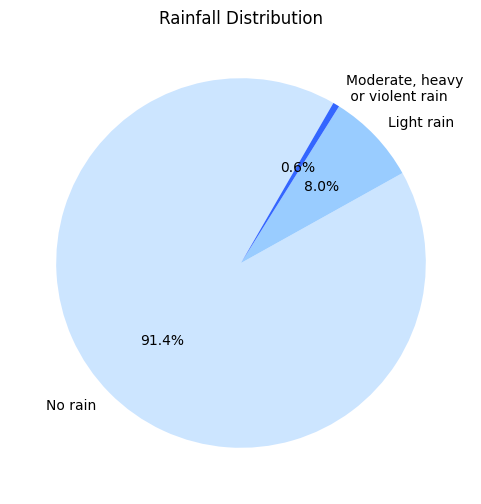

In [37]:
plt.figure(figsize=(6, 6))
prec_class.apply(combine_categories).value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=60,
    colors=["#cce5ff", "#99ccff", "#3366ff"]
)
plt.title("Rainfall Distribution")
plt.ylabel('') 
plt.savefig("pie_chart.png")
plt.show()

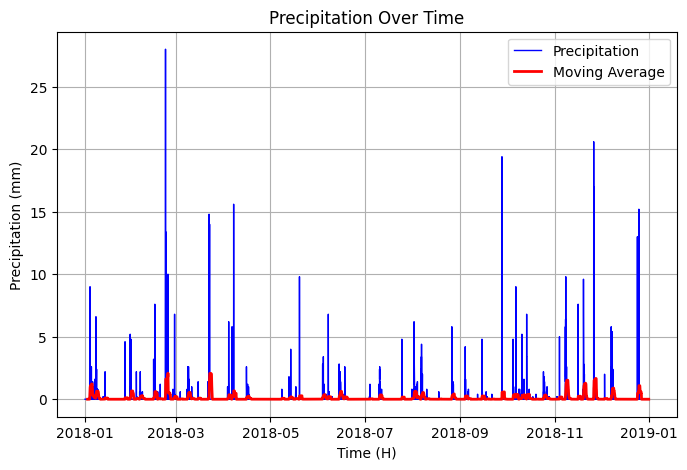

In [38]:
start_date = '2018-01-01 00:00'
end_date = '2019-01-01 00:00'

filtered_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]

rolling_mean = filtered_df["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].rolling(window=40).mean()

plt.figure(figsize=(8, 5))
plt.plot(
    filtered_df['timestamp'], 
    filtered_df["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"], 
    color='b', linewidth=1, label='Precipitation'
)
plt.plot(
    filtered_df['timestamp'],
    rolling_mean,
    color='r', linewidth=2, label='Moving Average'
)

plt.title('Precipitation Over Time')
plt.xlabel('Time (H)')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.legend()
plt.savefig("prec_over_time.png")
plt.show()

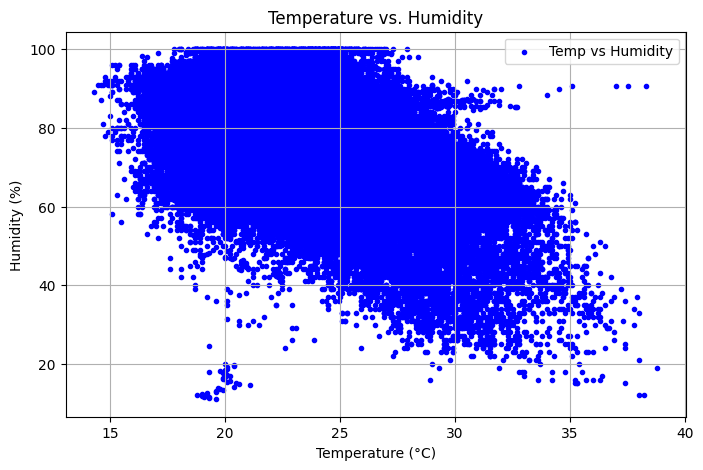

In [39]:
plt.figure(figsize=(8, 5))
plt.scatter(df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'], df['UMIDADE RELATIVA DO AR, HORARIA (%)'], color='b', s=9, label='Temp vs Humidity')
plt.title('Temperature vs. Humidity')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.grid(True)
plt.legend()
plt.savefig("temp_x_humidity.png")
plt.show()

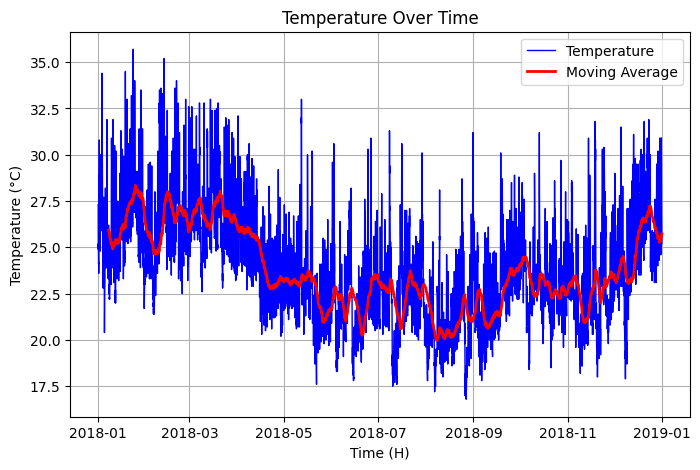

In [40]:
start_date = '2018-01-01 00:00'
end_date = '2019-01-01 00:00'

filtered_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]

# Calculate rolling mean (24-hour window)
rolling_mean = filtered_df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].rolling(window=160).mean()

plt.figure(figsize=(8, 5))
plt.plot(
    filtered_df['timestamp'], 
    filtered_df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'], 
    color='b', linewidth=1, label='Temperature'
)
plt.plot(
    filtered_df['timestamp'],
    rolling_mean,
    color='r', linewidth=2, label='Moving Average'
)

plt.title('Temperature Over Time')
plt.xlabel('Time (H)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.savefig("temp_over_time.png")
plt.show()

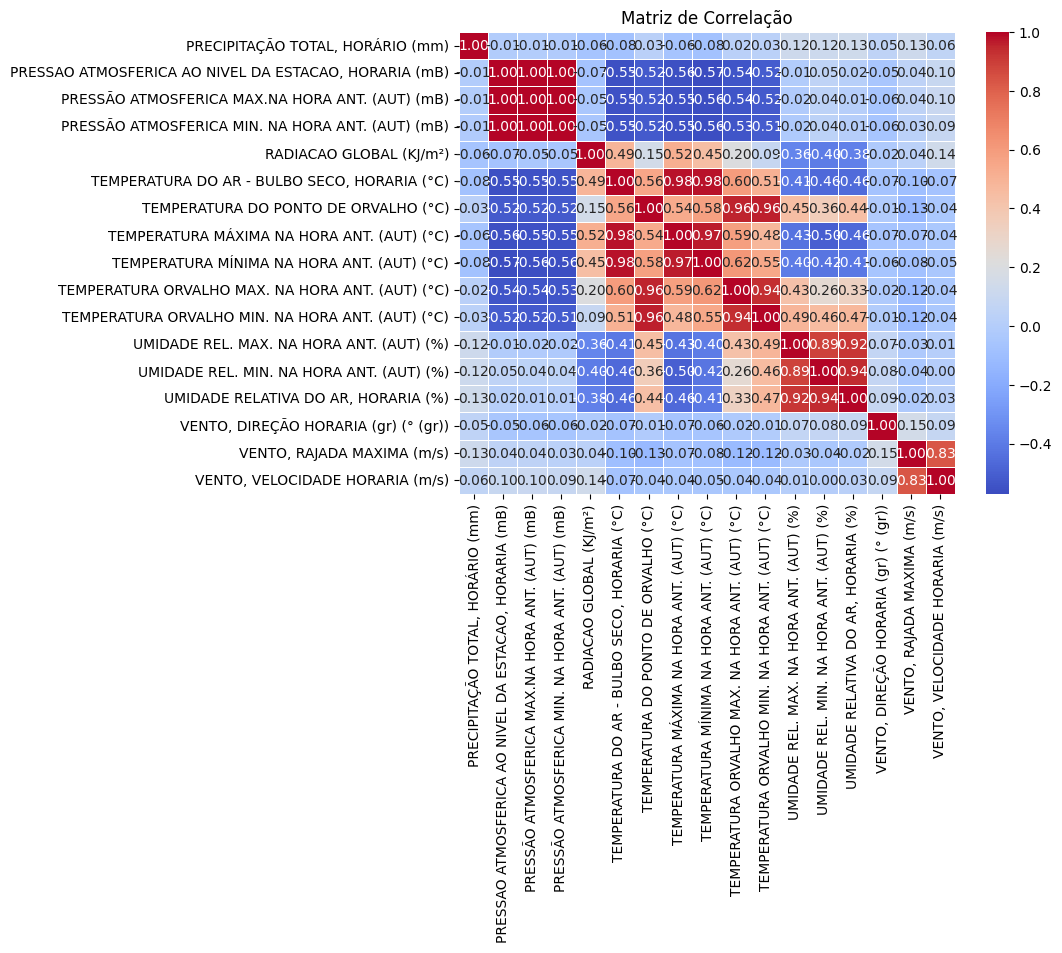

In [41]:
df_corr = df.drop(columns=['DATA', 'HORA', 'timestamp'])
correlation_matrix = df_corr.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

train and test split

In [68]:
def split_train_test(df, y_target, train_size, prec_now=False):
    X = df[[
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (KJ/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

    if (prec_now): X = pd.concat([X, df[['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']]], axis=1)
    
    y = df[y_target]

    X_train, X_test = X[:round(X.shape[0]*train_size)], X[round(X.shape[0]*train_size):]
    y_train, y_test = y[:round(y.shape[0]*train_size)], y[round(y.shape[0]*train_size):]

    return X_train, X_test, y_train, y_test

In [4]:
def train_xgboost(X_train, y_train, X_test, y_test, params):
    xgb_model = xgb.train(params, xgb.DMatrix(X_train, label=y_train), num_boost_round=100)
    
    predictions = xgb_model.predict(xgb.DMatrix(X_test))
    
    rmse = mean_squared_error(y_test, predictions)
    
    return xgb_model, predictions
    
def grid_search_xgboost(X_train, y_train, X_test, y_test):
    param_grid = {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5]
    }
    
    param_combinations = list(product(
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['subsample'],
        param_grid['colsample_bytree'],
        param_grid['min_child_weight']
    ))
    
    best_rmse = float('inf')
    best_params = None

    for combination in tqdm(param_combinations, desc="Grid Search Progress"):
        max_depth, learning_rate, subsample, colsample_bytree, min_child_weight = combination
        params = {
            'max_depth': max_depth,
            'eta': learning_rate,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'min_child_weight': min_child_weight,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse'
        }
        
        model, predictions = train_xgboost(X_train, y_train, X_test, y_test, params)
        rmse = mean_squared_error(y_test, predictions)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    
    print("Best parameters found:")
    print(best_params)
    print(f"Best RMSE: {best_rmse}")
    
    final_model, final_predictions = train_xgboost(X_train, y_train, X_test, y_test, best_params)
    
    return final_model, final_predictions, best_params

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MRSE: {np.sqrt(mean_squared_error(y_test, prediction))}")

def plot_real_vs_predicted(y_test, predictions):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, predictions, alpha=0.7, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Real vs Predicted Values")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_prediction_over_time(y_test, predictions, timestamps, start_date=None, end_date=None):
    timestamps = pd.to_datetime(timestamps)

    data = pd.DataFrame({
        'Timestamp': timestamps,
        'Actual': y_test,
        'Predicted': predictions
    })

    if start_date:
        data = data[data['Timestamp'] >= pd.to_datetime(start_date)]
    if end_date:
        data = data[data['Timestamp'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(data['Timestamp'], data['Actual'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(data['Timestamp'], data['Predicted'], label='Predicted Values', color='orange', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Actual vs. Predicted Values Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# XGBoost preciptation

## insant prec

In [60]:
X_train, X_test, y_train, y_test = split_train_test(df, 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 0.8)

tracker = EmissionsTracker(
    project_name="xgboost regression prec total hor",
    output_file='./codecarbon_emissions.csv',
    log_level = "critical"
)

tracker.start()

final_model, final_predictions, best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████████████████████| 243/243 [01:44<00:00,  2.32it/s]


Best parameters found:
{'max_depth': 4, 'eta': 0.2, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 3, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 0.4766868223195054
emissions=4.789270512173468e-05


In [63]:
evaluate_model(y_test, final_predictions)

MAE: 0.13036703636003183
MSE: 0.4766868223195054
MRSE: 0.690425102613966


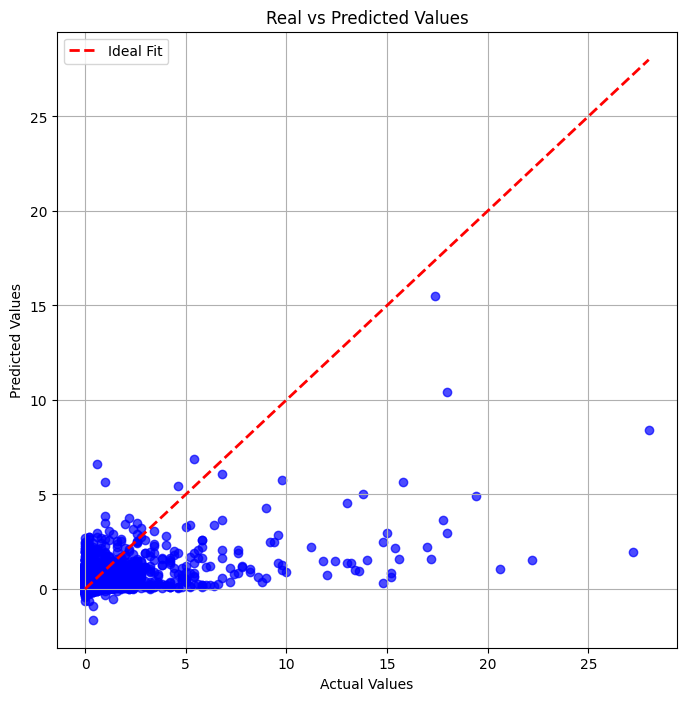

In [64]:
plot_real_vs_predicted(y_test, final_predictions)

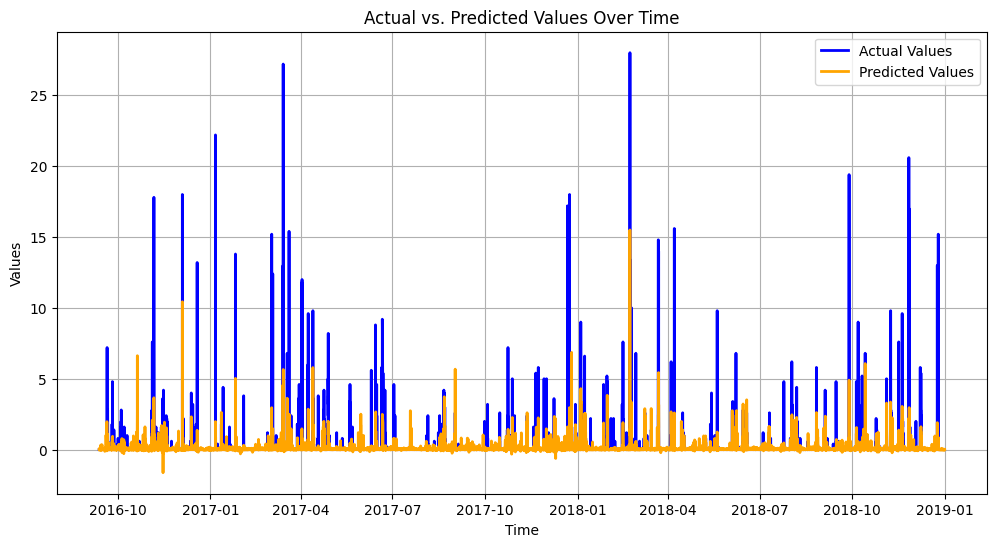

In [65]:
timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["timestamp"]

plot_prediction_over_time(y_test, final_predictions, timestamps_test)

## 4h ahead preciptation

In [51]:
X_train, X_test, y_train, y_test = split_train_test(df, "lag_preciptation_4h", 0.8, True)

tracker = EmissionsTracker(
    project_name="xgboost regression lag 4h",
    output_file='./codecarbon_emissions.csv',
    log_level = "critical"
)

tracker.start()

final_model, final_predictions, best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████████████████████| 243/243 [01:20<00:00,  3.03it/s]


Best parameters found:
{'max_depth': 4, 'eta': 0.01, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 3, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 0.6449045139793104
emissions=3.6719793474176153e-05


### Resultados

In [52]:
evaluate_model(y_test, final_predictions)

MAE: 0.1932069563912732
MSE: 0.6449045139793104
MRSE: 0.8030594710102797


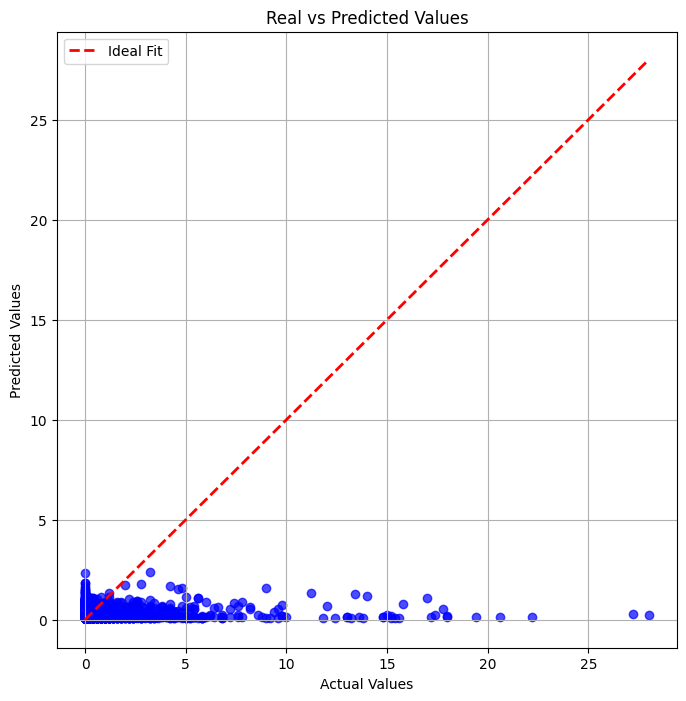

In [53]:
plot_real_vs_predicted(y_test, final_predictions)

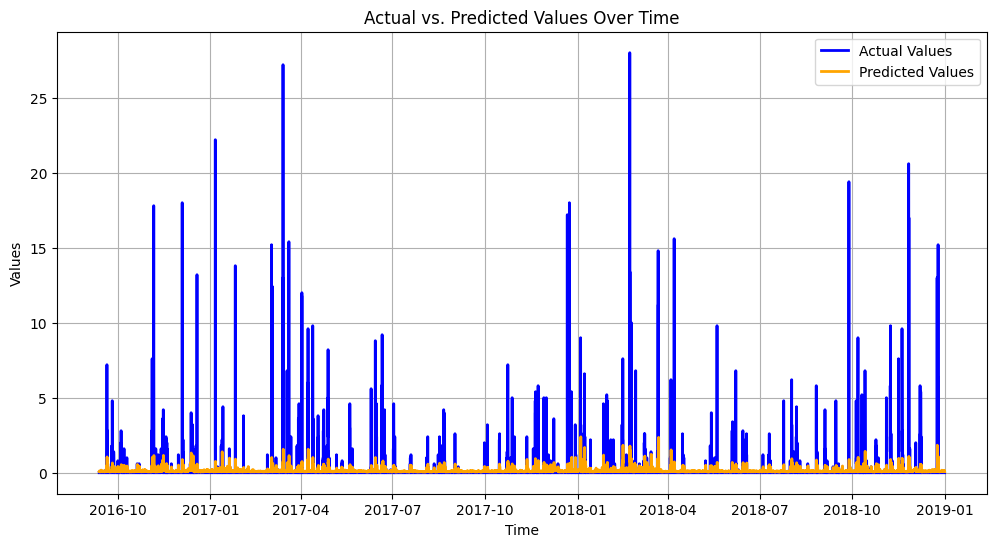

In [55]:
timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["timestamp"]

plot_prediction_over_time(y_test, final_predictions, timestamps_test)

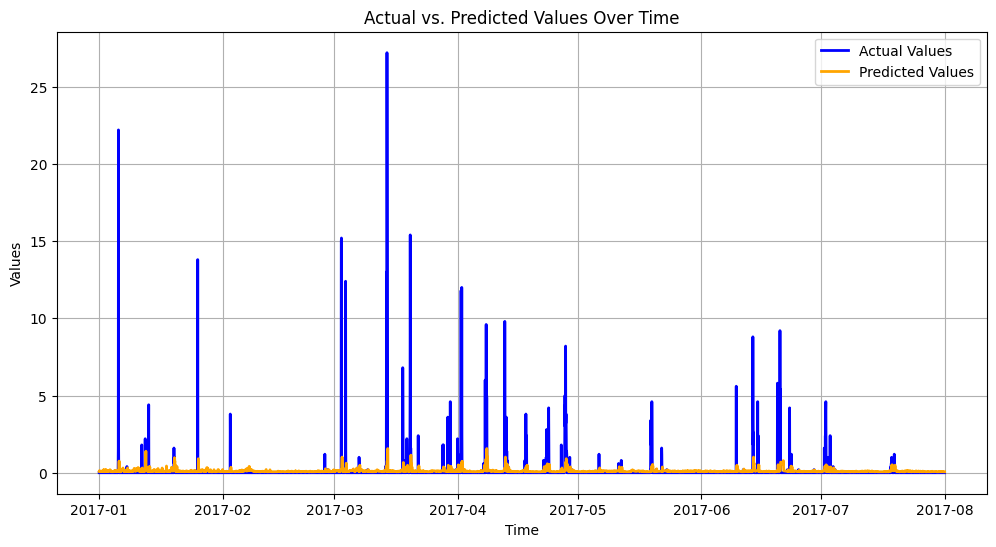

In [56]:
start_date = "2017-01-01"
end_date = "2017-08-01"

timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["timestamp"]

plot_prediction_over_time(y_test, final_predictions, timestamps_test, start_date, end_date)

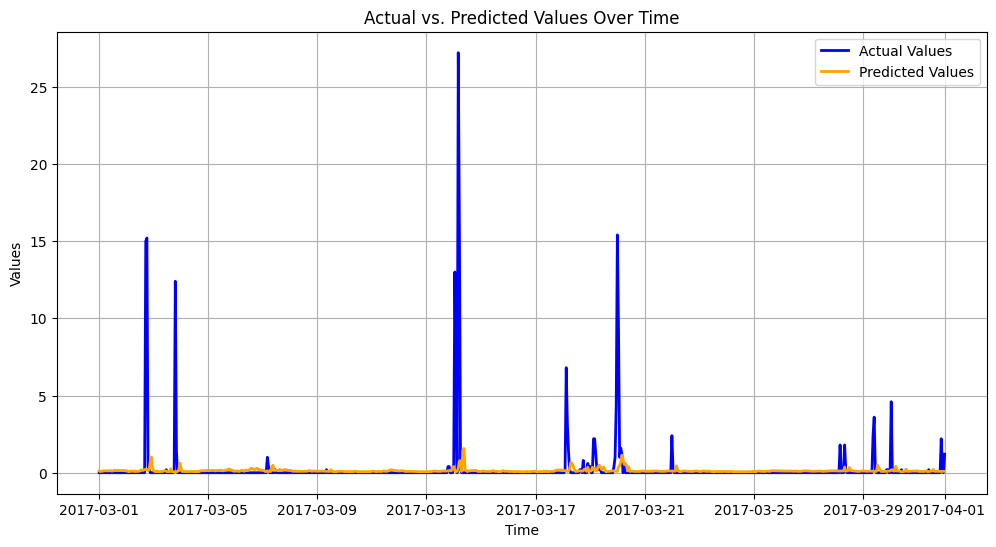

In [57]:
start_date = "2017-03-01"
end_date = "2017-04-01"

timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["timestamp"]

plot_prediction_over_time(y_test, final_predictions, timestamps_test, start_date, end_date)

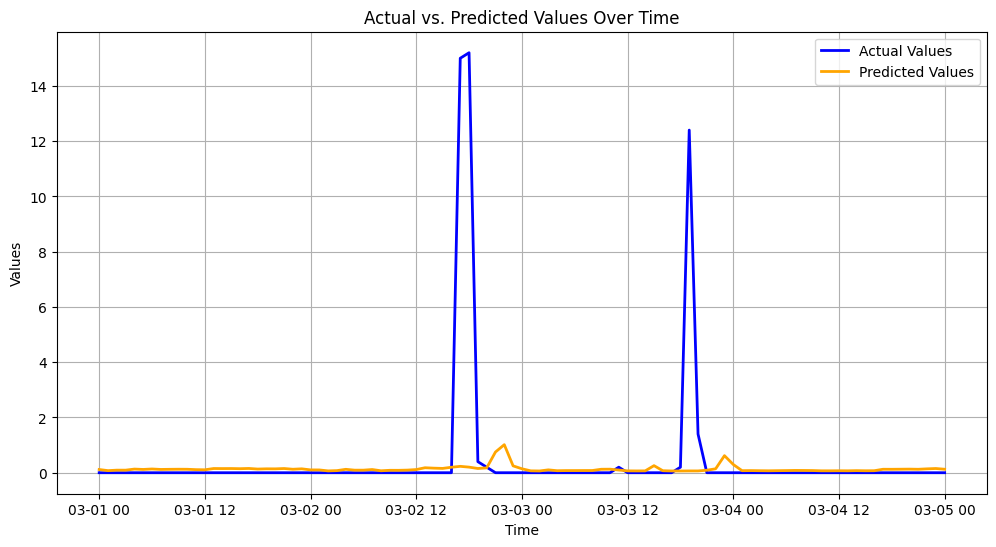

In [58]:
start_date = "2017-03-01"
end_date = "2017-03-05"

timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["timestamp"]

plot_prediction_over_time(y_test, final_predictions, timestamps_test, start_date, end_date)

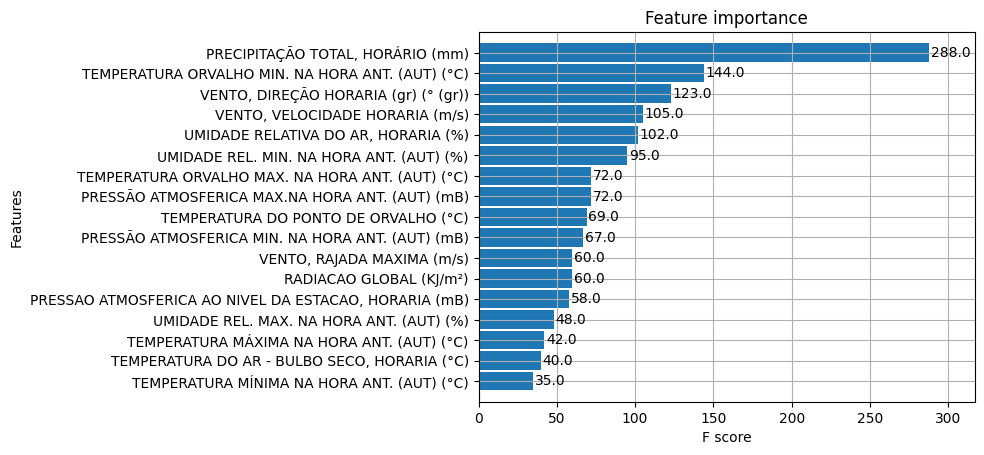

In [59]:
_ = plot_importance(final_model, height=0.9)

## instant preciptation removing 0 rain days

In [67]:
df_no_zero_rain = df[df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] != 0]
df_no_zero_rain

,DATA,HORA,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),...,UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",timestamp,lag_preciptation_1h,lag_preciptation_2h,lag_preciptation_3h,lag_preciptation_4h
136,2007-05-23,16:00,0.4,1005.1,1005.3,1005.1,43.6,23.2,18.9,23.2,...,76.0,77.0,307.0,5.3,1.8,2007-05-23 16:00:00,0.0,0.0,0.0,0.0
142,2007-05-23,22:00,0.2,1006.3,1006.3,1006.1,0.0,21.5,18.4,21.7,...,81.0,82.0,350.0,5.4,2.2,2007-05-23 22:00:00,0.0,0.0,0.0,0.0
150,2007-05-24,06:00,0.2,1008.0,1008.0,1007.7,0.3,18.9,17.8,19.2,...,91.0,93.0,244.0,15.2,10.3,2007-05-24 06:00:00,0.0,0.2,0.0,0.0
152,2007-05-24,08:00,0.2,1008.9,1009.3,1008.9,0.0,18.8,16.9,19.2,...,86.0,89.0,258.0,14.9,6.9,2007-05-24 08:00:00,0.0,0.0,0.2,0.2
155,2007-05-24,11:00,0.2,1011.2,1011.2,1010.7,32.2,18.8,15.7,20.3,...,76.0,82.0,247.0,13.1,8.8,2007-05-24 11:00:00,0.2,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101737,2018-12-25,01:00,0.2,1010.7,1010.9,1010.7,0.0,23.7,21.4,23.9,...,86.0,86.0,315.0,3.4,1.2,2018-12-25 01:00:00,0.0,0.0,0.0,0.0
101748,2018-12-25,12:00,6.4,1010.0,1010.0,1009.5,240.3,23.5,21.3,25.1,...,78.0,87.0,42.0,5.1,2.3,2018-12-25 12:00:00,0.2,0.0,15.2,1.4
101749,2018-12-25,13:00,0.2,1010.6,1010.6,1010.0,263.2,23.5,21.3,23.7,...,87.0,87.0,46.0,5.1,1.5,2018-12-25 13:00:00,0.0,15.2,1.4,0.0
101751,2018-12-25,15:00,15.2,1011.1,1011.1,1010.8,274.8,23.2,21.5,24.4,...,84.0,90.0,291.0,4.5,1.0,2018-12-25 15:00:00,1.4,0.0,0.0,0.0


In [69]:
X_train, X_test, y_train, y_test = split_train_test(df_no_zero_rain, 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 0.8)

tracker = EmissionsTracker(
    project_name="xgboost regression prec total hor",
    output_file='./codecarbon_emissions.csv',
    log_level = "critical"
)

tracker.start()

final_model, final_predictions, best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████████████████████| 243/243 [00:43<00:00,  5.56it/s]


Best parameters found:
{'max_depth': 4, 'eta': 0.2, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 8.745539687544564
emissions=1.9999991307472242e-05


In [70]:
evaluate_model(y_test, final_predictions)

MAE: 1.373414298575474
MSE: 8.745539687544564
MRSE: 2.9572858650364804


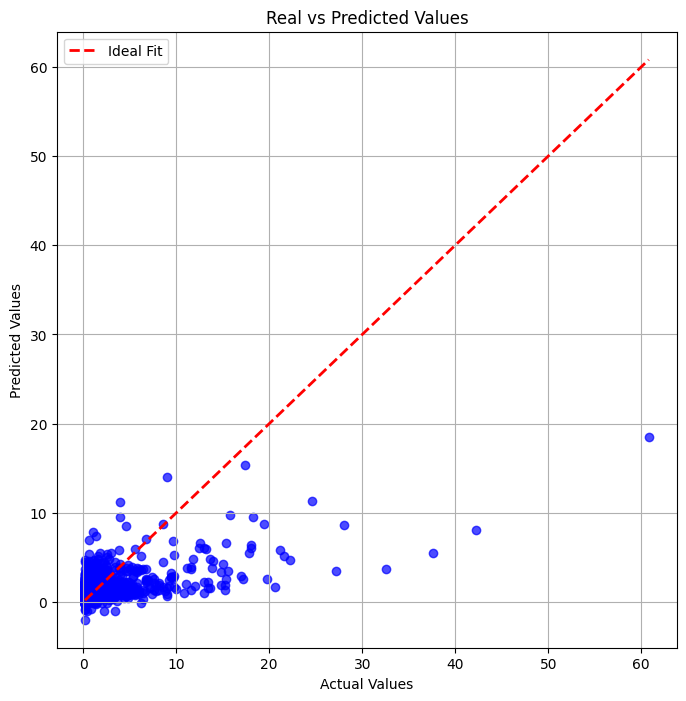

In [71]:
plot_real_vs_predicted(y_test, final_predictions)

## instant prec drop < 2.0

In [77]:
df_greater_than_1mm_rain = df[df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] > 1.0]
df_greater_than_1mm_rain

,DATA,HORA,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),...,UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",timestamp,lag_preciptation_1h,lag_preciptation_2h,lag_preciptation_3h,lag_preciptation_4h
308,2007-05-30,20:00,2.2,1018.7,1018.7,1018.4,0.3,17.2,15.4,17.7,...,82.0,89.0,217.0,18.1,11.4,2007-05-30 20:00:00,0.0,0.0,0.0,0.0
383,2007-06-02,23:00,1.2,1011.6,1011.7,1011.6,0.3,19.5,18.6,19.5,...,94.0,95.0,286.0,1.8,0.7,2007-06-02 23:00:00,0.0,0.2,0.4,0.2
938,2007-06-26,02:00,2.4,1021.3,1021.5,1021.3,0.0,20.6,18.2,21.1,...,83.0,86.0,77.0,7.2,3.3,2007-06-26 02:00:00,0.0,0.0,0.0,0.0
1025,2007-06-29,17:00,2.0,1016.7,1016.7,1016.7,17.5,20.3,18.7,20.8,...,89.0,90.0,215.0,6.3,3.2,2007-06-29 17:00:00,0.0,0.0,0.0,0.0
1440,2007-07-17,00:00,2.4,1015.6,1015.9,1015.5,0.4,18.8,17.5,18.8,...,92.0,92.0,4.0,2.7,1.0,2007-07-17 00:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101727,2018-12-24,15:00,5.4,1009.2,1009.2,1008.9,137.8,23.9,22.4,25.8,...,85.0,91.0,175.0,10.3,6.0,2018-12-24 15:00:00,13.0,0.4,0.2,0.0
101728,2018-12-24,16:00,13.0,1009.0,1009.6,1009.0,152.4,24.1,22.7,24.1,...,91.0,92.0,215.0,8.2,4.8,2018-12-24 16:00:00,0.4,0.2,0.0,0.0
101748,2018-12-25,12:00,6.4,1010.0,1010.0,1009.5,240.3,23.5,21.3,25.1,...,78.0,87.0,42.0,5.1,2.3,2018-12-25 12:00:00,0.2,0.0,15.2,1.4
101751,2018-12-25,15:00,15.2,1011.1,1011.1,1010.8,274.8,23.2,21.5,24.4,...,84.0,90.0,291.0,4.5,1.0,2018-12-25 15:00:00,1.4,0.0,0.0,0.0


In [78]:
X_train, X_test, y_train, y_test = split_train_test(df_greater_than_1mm_rain, 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 0.8)

tracker = EmissionsTracker(
    project_name="xgboost regression prec total hor",
    output_file='./codecarbon_emissions.csv',
    log_level = "critical"
)

tracker.start()

final_model, final_predictions, best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████████████████████| 243/243 [00:34<00:00,  7.12it/s]


Best parameters found:
{'max_depth': 4, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.6, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 10.821636870891414
emissions=1.5624541321589924e-05


In [79]:
evaluate_model(y_test, final_predictions)

MAE: 2.1903342483554233
MSE: 10.821636870891414
MRSE: 3.2896256429708552


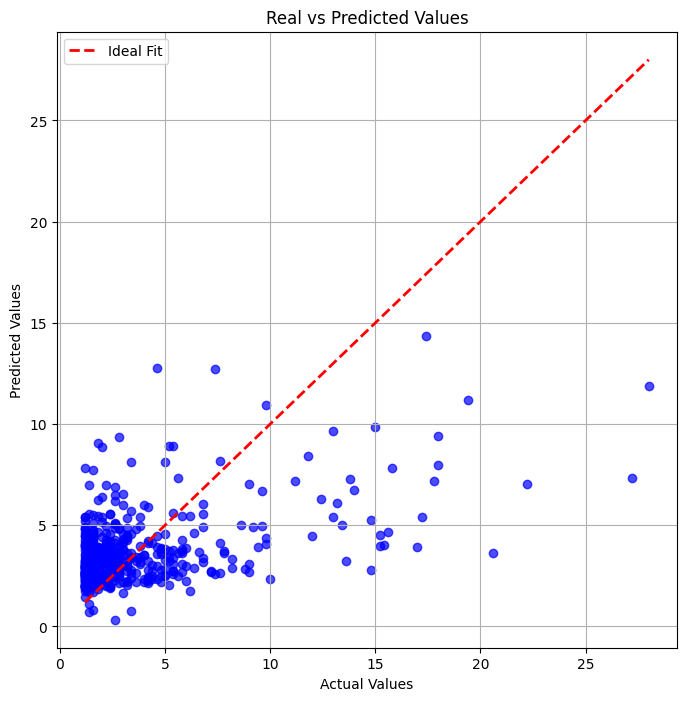

In [80]:
plot_real_vs_predicted(y_test, final_predictions)

## df > 10mm 

In [82]:
df_greater_than_10mm_rain = df[df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] > 10.0]
df_greater_than_10mm_rain

,DATA,HORA,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),...,UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",timestamp,lag_preciptation_1h,lag_preciptation_2h,lag_preciptation_3h,lag_preciptation_4h
3827,2007-10-24,11:00,13.0,1017.0,1017.0,1016.3,91.5,20.8,20.0,21.0,...,94.0,95.0,90.0,5.5,3.5,2007-10-24 11:00:00,14.2,12.4,9.8,5.4
3828,2007-10-24,12:00,14.2,1017.2,1017.2,1016.9,126.0,20.5,19.7,20.8,...,95.0,96.0,104.0,8.1,5.2,2007-10-24 12:00:00,12.4,9.8,5.4,5.0
3829,2007-10-24,13:00,12.4,1017.4,1017.4,1017.1,104.8,20.5,19.8,20.5,...,95.0,96.0,90.0,7.0,4.0,2007-10-24 13:00:00,9.8,5.4,5.0,5.4
3841,2007-10-25,01:00,17.4,1014.9,1015.2,1014.8,3.7,20.1,19.5,20.7,...,96.0,96.0,96.0,9.3,4.4,2007-10-25 01:00:00,0.0,0.0,0.0,0.0
4077,2007-11-03,21:00,12.6,1003.1,1004.0,1000.4,68.8,24.2,23.1,27.8,...,71.0,93.0,44.0,18.6,5.3,2007-11-03 21:00:00,0.6,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101049,2018-11-26,09:00,20.6,1012.4,1012.4,1011.6,21.2,21.8,20.4,22.2,...,91.0,92.0,297.0,3.9,1.2,2018-11-26 09:00:00,13.6,0.2,0.2,5.6
101050,2018-11-26,10:00,13.6,1012.9,1012.9,1012.2,298.6,22.1,20.8,22.2,...,91.0,92.0,304.0,5.2,1.8,2018-11-26 10:00:00,0.2,0.2,5.6,17.0
101054,2018-11-26,14:00,17.0,1014.0,1014.2,1013.9,249.1,21.6,20.4,21.8,...,92.0,93.0,270.0,11.2,2.8,2018-11-26 14:00:00,1.0,0.6,0.6,0.4
101728,2018-12-24,16:00,13.0,1009.0,1009.6,1009.0,152.4,24.1,22.7,24.1,...,91.0,92.0,215.0,8.2,4.8,2018-12-24 16:00:00,0.4,0.2,0.0,0.0


In [83]:
X_train, X_test, y_train, y_test = split_train_test(df_greater_than_10mm_rain, 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 0.8)

tracker = EmissionsTracker(
    project_name="xgboost regression prec total hor",
    output_file='./codecarbon_emissions.csv',
    log_level = "critical"
)

tracker.start()

final_model, final_predictions, best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████████████████████| 243/243 [00:18<00:00, 13.39it/s]


Best parameters found:
{'max_depth': 8, 'eta': 0.01, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 21.701022156981583
emissions=8.340417217624583e-06


In [84]:
evaluate_model(y_test, final_predictions)

MAE: 3.9126873536543414
MSE: 21.701022156981583
MRSE: 4.658435591159503


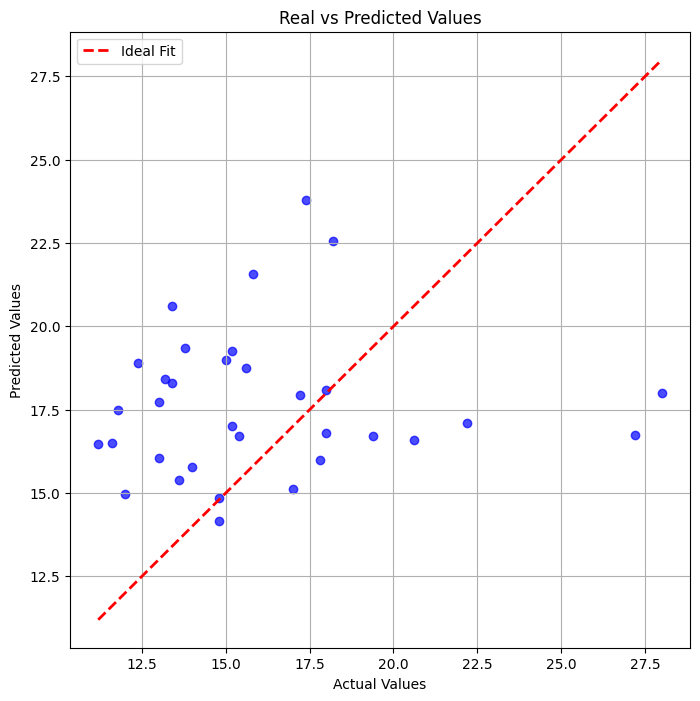

In [85]:
plot_real_vs_predicted(y_test, final_predictions)

# XGBoost temperature

In [17]:
train_size = 0.8

X = df[[
       'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (KJ/m²)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']

X_train_temp, X_test_temp = X[:round(X.shape[0]*train_size)], X[round(X.shape[0]*train_size):]
y_train_temp, y_test_temp = y[:round(y.shape[0]*train_size)], y[round(y.shape[0]*train_size):]

In [18]:
X_train_temp

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
18,0.0,1010.0,1010.1,1010.0,100.8,87.0,85.0,86.0,224.0,6.4,4.6
19,0.0,1010.4,1010.4,1010.3,35.6,88.0,86.0,87.0,234.0,7.9,5.5
35,0.0,1013.2,1013.2,1013.1,91.2,77.0,74.0,77.0,37.0,2.0,0.4
36,0.0,1013.5,1013.5,1013.2,141.0,82.0,77.0,82.0,104.0,1.5,0.9
37,0.0,1013.8,1013.9,1013.8,428.8,74.0,71.0,71.0,239.0,5.4,3.9
...,...,...,...,...,...,...,...,...,...,...,...
81724,0.0,1012.3,1012.8,1012.2,0.0,84.0,84.0,84.0,84.0,6.7,1.9
81725,0.0,1012.1,1012.3,1012.1,0.0,84.0,84.0,84.0,83.0,5.2,1.8
81726,0.0,1011.7,1012.1,1011.6,0.0,85.0,84.0,84.0,86.0,5.0,1.5
81727,0.0,1011.7,1011.8,1011.6,0.0,85.0,84.0,84.0,76.0,3.6,0.8


In [19]:
##tracker = EmissionsTracker(
  ##  project_name="grid search xgboost temperature 22-01 12:40",
  ##  output_file=codecarbon_output
##)

##tracker.start()

final_model, final_predictions, best_params = grid_search_xgboost(X_train_temp, y_train_temp, X_test_temp, y_test_temp)

##emissions: float = tracker.stop()
##print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████████████████████| 243/243 [01:01<00:00,  3.96it/s]


Best parameters found:
{'max_depth': 8, 'eta': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 3, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 2.9872601443492037


In [ ]:
tracker = EmissionsTracker(
    project_name="treino com xgboost temperature",
    output_file=codecarbon_output
)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 8,
    'subsample': 1,
    'colsample_bytree': 1.0,
    'alpha': 0.2,
    'n_estimators': 300,
    'scale_pos_weigth': 1
  }

tracker.start()

xgb_model2, predictions2 = train_xgboost(X_train=X_train_temperature, X_test=X_test_temperature,y_test=y_test_temperature , y_train=y_train_temperature, params=params)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

[codecarbon WARNING @ 00:56:23] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 00:56:23] [setup] RAM Tracking...
[codecarbon INFO @ 00:56:23] [setup] GPU Tracking...
[codecarbon INFO @ 00:56:23] No GPU found.
[codecarbon INFO @ 00:56:23] [setup] CPU Tracking...
[codecarbon WARNING @ 00:56:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 00:56:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 00:56:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 00:56:25] >>> Tracker's metadata:
[codecarbon INFO @ 00:56:25]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 00:56:25]   Python version: 3.10.12
[codecarbon INFO @ 00:56:25]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 00:56:25]   Available RAM : 12.675 GB
[codecarbon INFO @ 00:56:25]   CPU count: 2
[codecarbon INFO @ 00:56:25]   CP

RMSE: 0.31619503951556194
emissions=7.078574235973128e-05


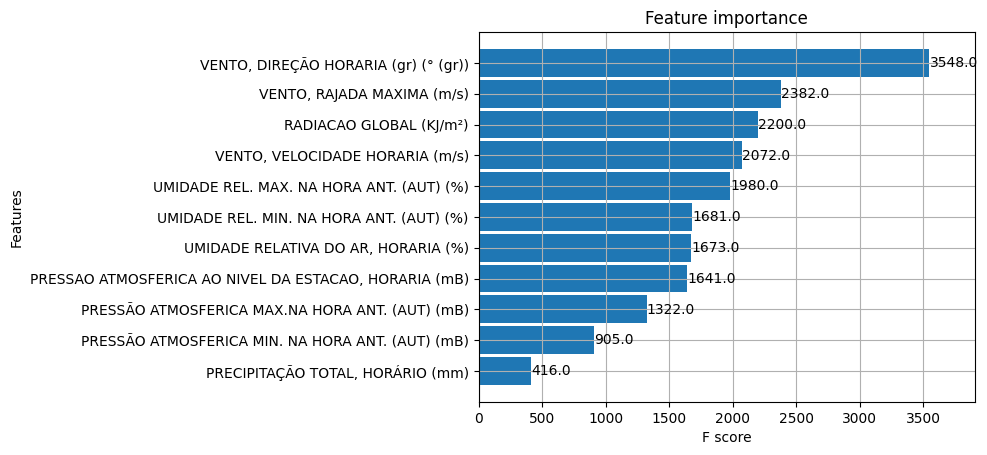

In [22]:
_ = plot_importance(final_model, height=0.9)

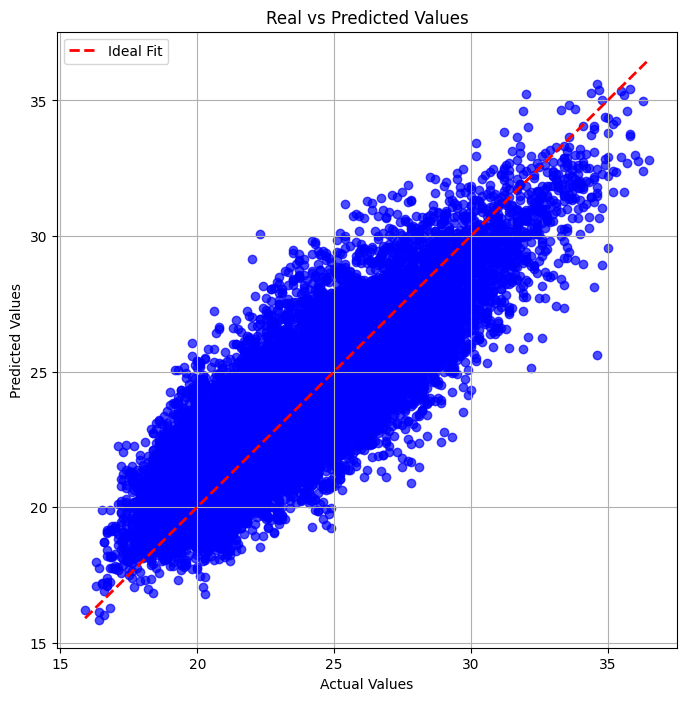

In [23]:
plot_real_vs_predicted(y_test_temp, final_predictions)

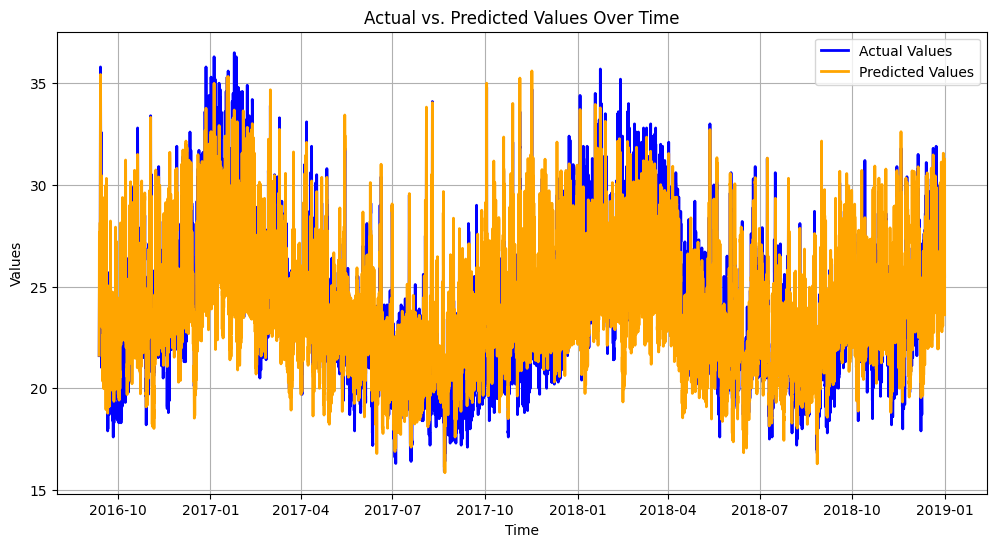

In [24]:
timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["timestamp"]

plot_prediction_over_time(y_test_temp, final_predictions, timestamps_test)

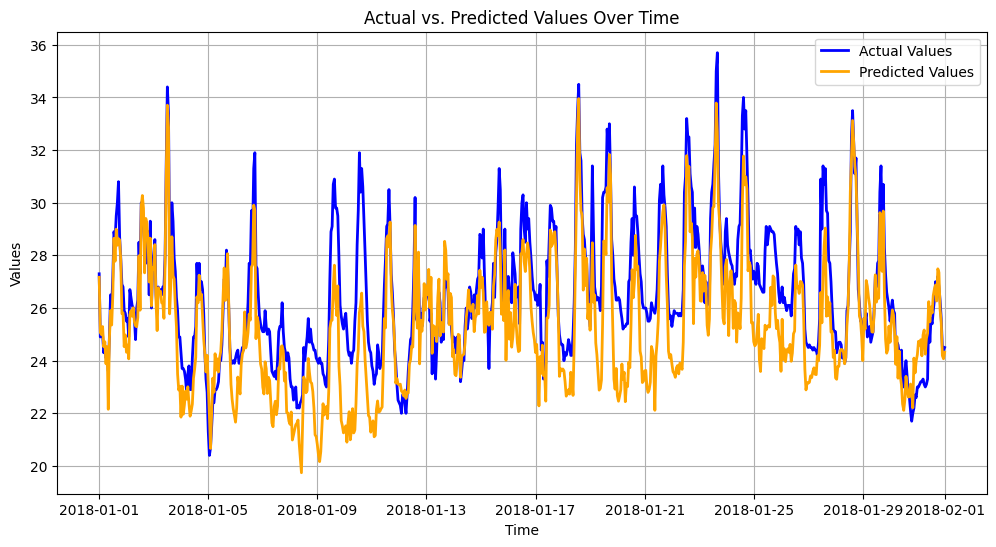

In [27]:
start_date = "2018-01-01"
end_date = "2018-02-01"

timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["timestamp"]

plot_prediction_over_time(y_test_temp, final_predictions, timestamps_test, start_date, end_date)

# Entendendo os dados

In [ ]:
df = df[df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'] != 0]

idx_min_temp = df.groupby('Ano')['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].idxmin()

dia_menos_quente = df.loc[idx_min_temp, ['Ano', 'DATA', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']]

print(dia_menos_quente)

        Ano       DATA  TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)
1748   2007 2007-07-29                                          14.3
11744  2008 2008-09-18                                          15.7
19848  2009 2009-08-22                                          16.4
26934  2010 2010-06-13                                          16.1
36321  2011 2011-07-09                                          15.1
47010  2012 2012-09-26                                          15.7
54236  2013 2013-07-24                                          14.5
63488  2014 2014-08-14                                          15.0
71284  2015 2015-07-05                                          16.5
79545  2016 2016-06-13                                          15.1
89965  2017 2017-08-21                                          15.9
98863  2018 2018-08-27                                          16.8


In [ ]:
idx_max_temp = df.groupby('Ano')['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].idxmax()

dia_mais_quente = df.loc[idx_max_temp, ['Ano', 'DATA', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']]
print(dia_mais_quente)

        Ano       DATA  TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)
4023   2007 2007-11-01                                          37.3
5918   2008 2008-01-19                                          35.0
22335  2009 2009-12-03                                          35.5
24760  2010 2010-03-14                                          36.8
37574  2011 2011-08-30                                          35.1
46839  2012 2012-09-19                                          38.8
56894  2013 2013-11-12                                          37.9
66613  2014 2014-12-22                                          38.0
75592  2015 2015-12-31                                          37.8
77007  2016 2016-02-28                                          35.8
84953  2017 2017-01-24                                          36.5
93688  2018 2018-01-23                                          35.7


In [ ]:
df['UMIDADE RELATIVA DO AR, HORARIA (%)'].fillna(0, inplace=True)

idx_min_temp = df.groupby('Ano')['UMIDADE RELATIVA DO AR, HORARIA (%)'].idxmin()

dia_menos_quente = df.loc[idx_min_temp, ['Ano', 'DATA', 'UMIDADE RELATIVA DO AR, HORARIA (%)']]

print(dia_menos_quente)

        Ano       DATA  UMIDADE RELATIVA DO AR, HORARIA (%)
3107   2007 2007-09-24                                 17.0
11462  2008 2008-09-06                                 21.0
22513  2009 2009-12-11                                  0.0
23933  2010 2010-02-08                                  0.0
37573  2011 2011-08-30                                 22.0
46839  2012 2012-09-19                                 19.0
49336  2013 2013-01-01                                 34.0
63757  2014 2014-08-25                                 22.0
67070  2015 2015-01-10                                 24.0
80319  2016 2016-07-15                                 22.0
89537  2017 2017-08-03                                 25.0
97383  2018 2018-06-26                                 32.0


In [ ]:
idx_min_temp = df.groupby('Ano')['UMIDADE RELATIVA DO AR, HORARIA (%)'].idxmin()

dia_menos_quente = df.loc[idx_min_temp, ['Ano', 'DATA', 'UMIDADE RELATIVA DO AR, HORARIA (%)']]

print(dia_menos_quente)

        Ano       DATA  UMIDADE RELATIVA DO AR, HORARIA (%)
3107   2007 2007-09-24                                 17.0
11462  2008 2008-09-06                                 21.0
22515  2009 2009-12-11                                 24.0
27746  2010 2010-07-17                                 11.0
37573  2011 2011-08-30                                 22.0
46839  2012 2012-09-19                                 19.0
49336  2013 2013-01-01                                 34.0
63757  2014 2014-08-25                                 22.0
67070  2015 2015-01-10                                 24.0
80319  2016 2016-07-15                                 22.0
89537  2017 2017-08-03                                 25.0
97383  2018 2018-06-26                                 32.0


In [ ]:
resultados = []

for ano, grupo_ano in df.groupby('Ano'):
    media_temperaturas_por_mes = grupo_ano.groupby('Mês')['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].mean()

    mes_mais_quente = media_temperaturas_por_mes.idxmax()

    media_mais_quente = media_temperaturas_por_mes.max()

    resultados.append({'Ano': ano, 'Mês': mes_mais_quente, 'Média de Temperatura': media_mais_quente})

resultados = pd.DataFrame(resultados)

resultados['Média de Temperatura'] = resultados['Média de Temperatura'].round(2)

print(resultados)

     Ano  Mês  Média de Temperatura
0   2007   12                 25.08
1   2008    2                 24.75
2   2009   11                 26.69
3   2010    1                 28.23
4   2011    1                 26.55
5   2012   12                 26.06
6   2013    2                 26.43
7   2014    1                 26.86
8   2015    1                 28.75
9   2016    2                 27.17
10  2017    1                 28.90
11  2018    3                 26.84


In [ ]:
resultados = []

for ano, grupo_ano in df.groupby('Ano'):
    media_temperaturas_por_mes = grupo_ano.groupby('Mês')['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].mean()

    mes_mais_frio = media_temperaturas_por_mes.idxmin()

    media_mais_fria = media_temperaturas_por_mes.min()

    resultados.append({'Ano': ano, 'Mês': mes_mais_frio, 'Média de Temperatura': media_mais_fria})

resultados = pd.DataFrame(resultados)

resultados['Média de Temperatura'] = resultados['Média de Temperatura'].round(2)

print(resultados)

     Ano  Mês  Média de Temperatura
0   2007    5                 21.03
1   2008    9                 21.20
2   2009    7                 21.18
3   2010    6                 21.28
4   2011    9                 20.47
5   2012    8                 21.01
6   2013    7                 21.02
7   2014    7                 21.14
8   2015    8                 21.40
9   2016    6                 20.15
10  2017    8                 20.42
11  2018    8                 20.87


Valores de correlação para a coluna 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)':


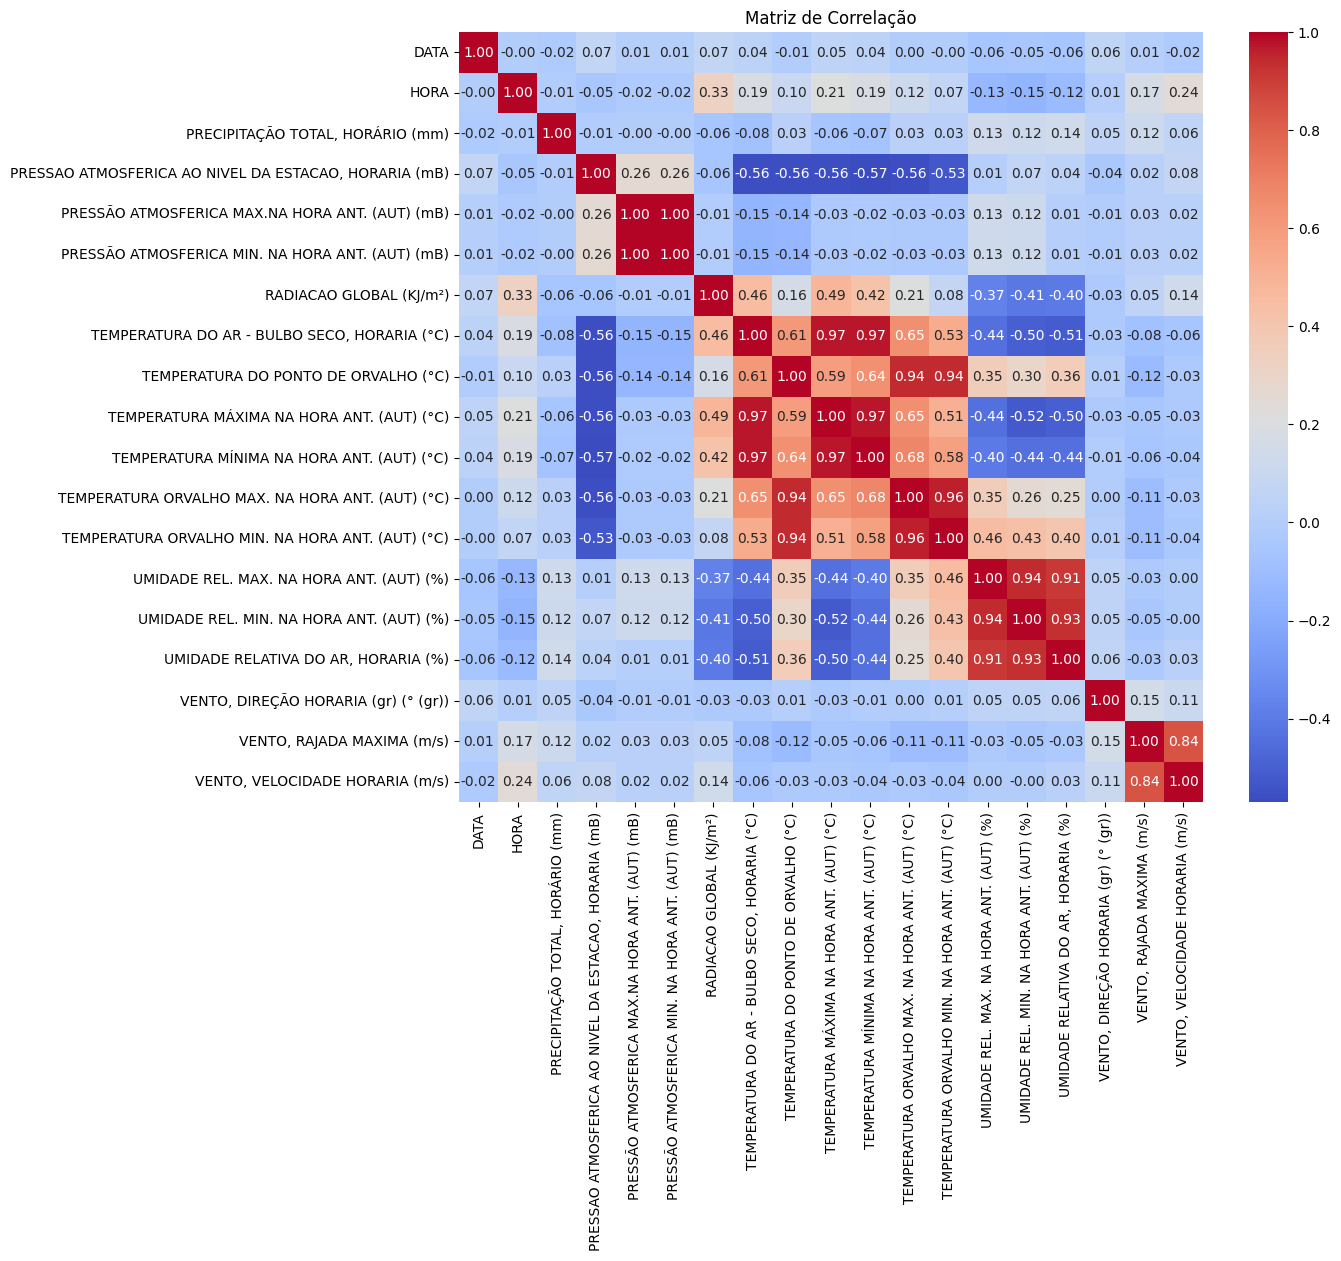

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df.drop(columns=['Ano', 'Mês'])

correlation_matrix = df.corr()

correlation_matrix = correlation_matrix.round(2)
print("Valores de correlação para a coluna 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)':")

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

In [ ]:
correlacoes_temperatura = correlation_matrix['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']
print(correlacoes_temperatura)

DATA                                                     0.04
HORA                                                     0.19
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                        -0.08
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)   -0.56
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)         -0.15
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)        -0.15
RADIACAO GLOBAL (KJ/m²)                                  0.46
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)             1.00
TEMPERATURA DO PONTO DE ORVALHO (°C)                     0.61
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)               0.97
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)               0.97
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)         0.65
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)         0.53
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                -0.44
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                -0.50
UMIDADE RELATIVA DO AR, HORARIA (%)                     -0.51
VENTO, D

In [ ]:
temperatura_correlation = correlation_matrix['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']

maiores_correlacoes_absolutas = temperatura_correlation.abs().sort_values(ascending=False)

maiores_correlacoes = maiores_correlacoes_absolutas[maiores_correlacoes_absolutas.index != 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']

print("Maiores correlações com a temperatura:")
print(maiores_correlacoes)

Maiores correlações com a temperatura:
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)               0.97
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)               0.97
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)         0.65
TEMPERATURA DO PONTO DE ORVALHO (°C)                     0.61
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    0.56
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)         0.53
UMIDADE RELATIVA DO AR, HORARIA (%)                      0.51
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                 0.50
RADIACAO GLOBAL (KJ/m²)                                  0.46
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 0.44
HORA                                                     0.19
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          0.15
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)         0.15
VENTO, RAJADA MAXIMA (m/s)                               0.08
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                         0.08
VENTO, VELOCIDADE HORARIA (m/s)

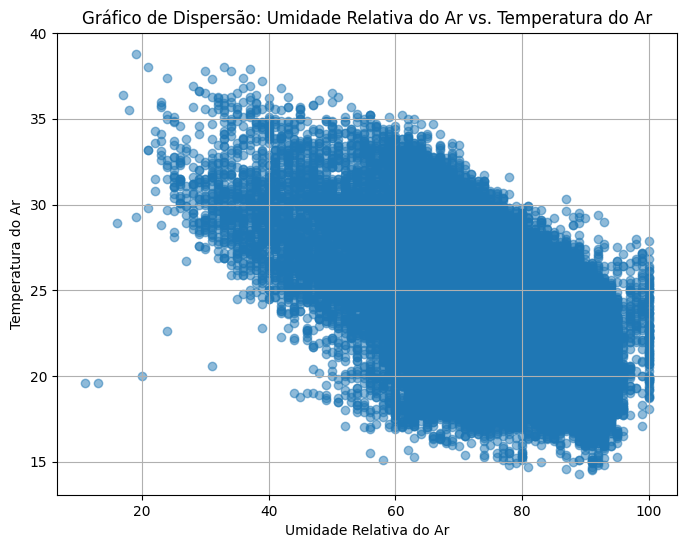

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df['UMIDADE RELATIVA DO AR, HORARIA (%)'], df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'], alpha=0.5)
plt.title('Gráfico de Dispersão: Umidade Relativa do Ar vs. Temperatura do Ar')
plt.xlabel('Umidade Relativa do Ar')
plt.ylabel('Temperatura do Ar')
plt.grid(True)
plt.show()

# CNN-LSTM

,DATA,HORA,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),...,UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",timestamp,lag_preciptation_1h,lag_preciptation_2h,lag_preciptation_3h,lag_preciptation_4h
18,2007-05-18,18:00,0.0,1010.0,1010.1,1010.0,100.8,23.5,21.1,23.8,...,85.0,86.0,224.0,6.4,4.6,2007-05-18 18:00:00,0.0,0.0,0.0,0.0
19,2007-05-18,19:00,0.0,1010.4,1010.4,1010.3,35.6,23.2,21.0,23.3,...,86.0,87.0,234.0,7.9,5.5,2007-05-18 19:00:00,0.0,0.0,0.0,0.0
35,2007-05-19,11:00,0.0,1013.2,1013.2,1013.1,91.2,23.6,19.3,23.6,...,74.0,77.0,37.0,2.0,0.4,2007-05-19 11:00:00,0.0,0.0,0.0,0.0
36,2007-05-19,12:00,0.0,1013.5,1013.5,1013.2,141.0,23.9,20.6,23.9,...,77.0,82.0,104.0,1.5,0.9,2007-05-19 12:00:00,0.0,0.0,0.0,0.0
37,2007-05-19,13:00,0.0,1013.8,1013.9,1013.8,428.8,25.0,19.3,25.0,...,71.0,71.0,239.0,5.4,3.9,2007-05-19 13:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101899,2018-12-31,19:00,0.0,1006.7,1006.7,1006.0,1410.0,27.8,23.4,28.6,...,73.0,77.0,130.0,8.0,6.6,2018-12-31 19:00:00,0.0,0.0,0.0,0.0
101900,2018-12-31,20:00,0.0,1006.6,1007.1,1006.6,637.0,26.7,23.4,27.8,...,77.0,82.0,129.0,9.1,4.3,2018-12-31 20:00:00,0.0,0.0,0.0,0.0
101901,2018-12-31,21:00,0.0,1007.2,1007.4,1006.6,302.5,26.1,22.8,26.8,...,82.0,82.0,103.0,5.4,2.1,2018-12-31 21:00:00,0.0,0.0,0.0,0.0
101902,2018-12-31,22:00,0.0,1007.5,1007.5,1007.2,41.5,25.7,22.8,26.2,...,82.0,84.0,135.0,3.3,1.5,2018-12-31 22:00:00,0.0,0.0,0.0,0.0
